In [ ]:
import os, json, math, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/SIH/data/raw_data"

'Ayrshire cattle'	     Jaffrabadi       Mehsana		 Red_Sindhi
'Brown Swiss cattle'	    'Jersey cattle'   Murrah		 Sahiwal
'Holstein Friesian cattle'   Kankrej	     'Red Dane cattle'	 Surti


In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/SIH/data/raw_data"

In [ ]:
if os.path.isdir(DATA_DIR):
  print(f"Folder found: {DATA_DIR}")
else:
  print(f"Folder not found: {DATA_DIR}")

Folder found: /content/drive/MyDrive/SIH/data/raw_data


In [ ]:
def explore_dataset(data_dir):
    """
    Explore the dataset structure and show sample counts
    """
    print("Dataset Structure:")
    print("-" * 40)

    breeds = []
    image_counts = []

    if os.path.exists(data_dir):
        for breed_folder in sorted(os.listdir(data_dir)):
            breed_path = os.path.join(data_dir, breed_folder)
            if os.path.isdir(breed_path):
                image_count = len([f for f in os.listdir(breed_path)
                                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                breeds.append(breed_folder)
                image_counts.append(image_count)
                print(f"{breed_folder}: {image_count} images")

    total_images = sum(image_counts)
    print("-" * 40)
    print(f"Total Images: {total_images}")
    print(f"Total Breeds: {len(breeds)}")

    # Plot distribution
    plt.figure(figsize=(12, 6))
    plt.bar(breeds, image_counts, color=['skyblue' if 'cattle' in breed.lower() else 'lightcoral' for breed in breeds])
    plt.title('Distribution of Images per Breed')
    plt.xlabel('Breed')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return breeds, image_counts

Dataset Structure:
----------------------------------------
Ayrshire cattle: 260 images
Brown Swiss cattle: 238 images
Holstein Friesian cattle: 254 images
Jaffrabadi: 101 images
Jersey cattle: 252 images
Kankrej: 178 images
Mehsana: 94 images
Murrah: 173 images
Red Dane cattle: 204 images
Red_Sindhi: 162 images
Sahiwal: 459 images
Surti: 59 images
----------------------------------------
Total Images: 2434
Total Breeds: 12


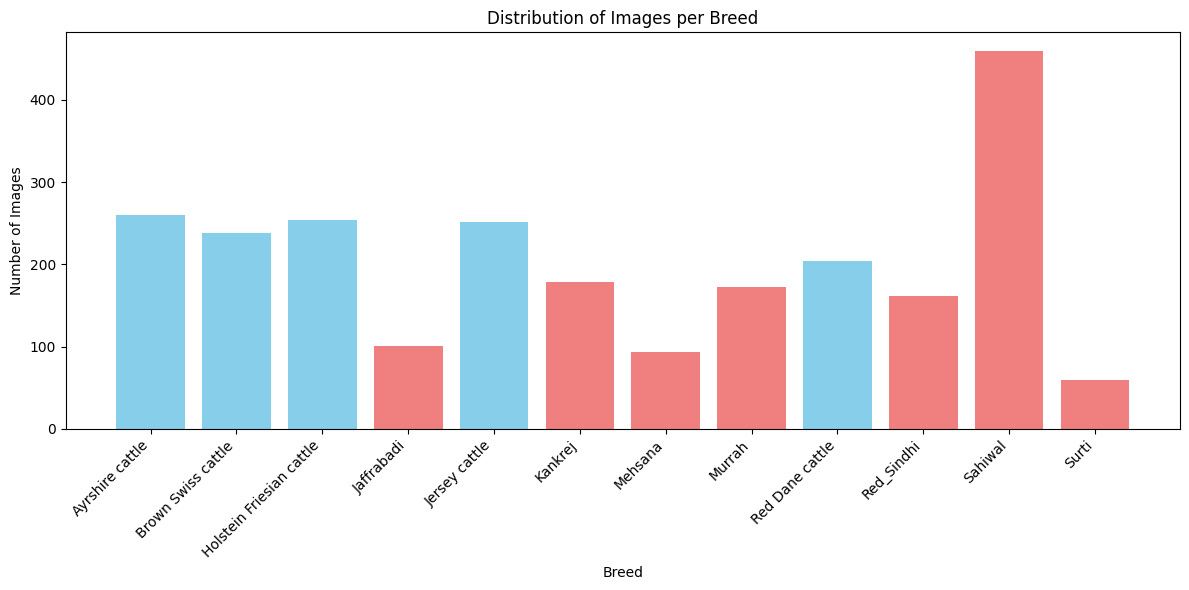

In [ ]:
# Explore your dataset
breeds, counts = explore_dataset(DATA_DIR)

In [ ]:
import os
for cls in sorted(os.listdir(DATA_DIR)):
    cls_path = os.path.join(DATA_DIR, cls)
    if os.path.isdir(cls_path):
        print(cls, len(os.listdir(cls_path)))


Ayrshire cattle 260
Brown Swiss cattle 238
Holstein Friesian cattle 254
Jaffrabadi 102
Jersey cattle 252
Kankrej 179
Mehsana 95
Murrah 173
Red Dane cattle 204
Red_Sindhi 166
Sahiwal 459
Surti 64


In [ ]:
IMG_SIZE = 224  # ResNet50 default
BATCH_SIZE = 32
VAL_SPLIT = 0.20       # 20% for val+test (we'll split this in half later into val and test)
SEED = 42
COLOR_MODE = "rgb"
LEARNING_RATE = 0.0001

In [ ]:
# Load datasets (train / val_temp)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",       # Automatically label based on folder
    label_mode="int",        # keep integer labels; we can one-hot later inside the model
    class_names=None,        # infer from subfolder names
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),     # will resize for you
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="training",
)


Found 2446 files belonging to 12 classes.
Using 1957 files for training.


In [ ]:
val_temp_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="validation",
)

Found 2446 files belonging to 12 classes.
Using 489 files for validation.


In [ ]:
# Save class names (folder names) for later use
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Ayrshire cattle', 'Brown Swiss cattle', 'Holstein Friesian cattle', 'Jaffrabadi', 'Jersey cattle', 'Kankrej', 'Mehsana', 'Murrah', 'Red Dane cattle', 'Red_Sindhi', 'Sahiwal', 'Surti']


In [ ]:
# Check the labels
#print("Class labels:", train_ds.class_indices)
label_map = {i: name for i, name in enumerate(class_names)}
print(label_map)

{0: 'Ayrshire cattle', 1: 'Brown Swiss cattle', 2: 'Holstein Friesian cattle', 3: 'Jaffrabadi', 4: 'Jersey cattle', 5: 'Kankrej', 6: 'Mehsana', 7: 'Murrah', 8: 'Red Dane cattle', 9: 'Red_Sindhi', 10: 'Sahiwal', 11: 'Surti'}


In [ ]:
# Save mapping to file
label_map = {i: name for i, name in enumerate(class_names)}
#print(label_map)
with open("/content/drive/MyDrive/SIH/data/class_names.json", "w") as f:
    json.dump(label_map, f, indent=2)
print("/content/drive/MyDrive/SIH/data/class_names.json")

/content/drive/MyDrive/SIH/data/class_names.json


In [ ]:
for images, labels in train_ds.take(1): # take first batch
  print("Labels: ",labels.numpy())
  print("Class names: ", [class_names[i] for i in labels.numpy()])

Labels:  [ 0  2  4  5  9  7  3  7  2  5  1  0  5  3 10  1  5  1  4  1  8  7  8 11
 10 11  7  9  2  0  7  5]
Class names:  ['Ayrshire cattle', 'Holstein Friesian cattle', 'Jersey cattle', 'Kankrej', 'Red_Sindhi', 'Murrah', 'Jaffrabadi', 'Murrah', 'Holstein Friesian cattle', 'Kankrej', 'Brown Swiss cattle', 'Ayrshire cattle', 'Kankrej', 'Jaffrabadi', 'Sahiwal', 'Brown Swiss cattle', 'Kankrej', 'Brown Swiss cattle', 'Jersey cattle', 'Brown Swiss cattle', 'Red Dane cattle', 'Murrah', 'Red Dane cattle', 'Surti', 'Sahiwal', 'Surti', 'Murrah', 'Red_Sindhi', 'Holstein Friesian cattle', 'Ayrshire cattle', 'Murrah', 'Kankrej']


In [ ]:
# revesre mapping
class_to_idx = {name: i for i, name in enumerate(class_names)}
print(class_to_idx)


{'Ayrshire cattle': 0, 'Brown Swiss cattle': 1, 'Holstein Friesian cattle': 2, 'Jaffrabadi': 3, 'Jersey cattle': 4, 'Kankrej': 5, 'Mehsana': 6, 'Murrah': 7, 'Red Dane cattle': 8, 'Red_Sindhi': 9, 'Sahiwal': 10, 'Surti': 11}


In [ ]:
# Split val_temp into real val and test (50/50)

In [ ]:
# In TensorFlow, a tf.data.Dataset doesn’t store everything in memory — it’s a pipeline of operations (like “read images → resize → batch → shuffle”)
# To know how many batches are inside the dataset, you use: tf.data.experimental.cardinality(dataset)
# This returns a special TensorFlow object (tf.Tensor) representing the count of batches
val_temp_batches = tf.data.experimental.cardinality(val_temp_ds).numpy()
print(val_temp_batches)

16


In [ ]:
test_ds = val_temp_ds.take(val_temp_batches // 2)
val_ds  = val_temp_ds.skip(val_temp_batches // 2)

In [ ]:
print("Batches -> train:", tf.data.experimental.cardinality(train_ds).numpy(),
      "| val:", tf.data.experimental.cardinality(val_ds).numpy(),
      "| test:", tf.data.experimental.cardinality(test_ds).numpy())

Batches -> train: 62 | val: 8 | test: 8


In [ ]:
print(32*(31+4+4))
print(260+238+254+252+204) # last batch are not full

1248
1208


Data augmentation (training only)

In [ ]:
#    Keep augmentations conservative to avoid distorting breed characteristics.
#    NOTE: These layers work fine before preprocess_input(i.e., before preprocess_input). Augmentation works on normal images (0–255 pixel range)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
    tf.keras.layers.RandomBrightness(0.15),  # brightness variation
    tf.keras.layers.RandomContrast(0.15),    # contrast variation
    #tf.keras.layers.RandomCrop(height=200, width=200),  # Random crop then resize
    #tf.keras.layers.Resizing(224, 224)
], name="enhanced_data_augmentation")

Preprocess for ResNet50

In [ ]:
#    Use tf.keras.applications.resnet50.preprocess_input (Caffe-style: BGR, mean subtraction).
#    Do NOT also rescale 1/255.

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def add_augmentation(image, label):
    # Apply only on training
    image = data_augmentation(image, training=True)
    return image, label

In [ ]:
def preprocess_for_resnet(image, label):
    image = tf.cast(image, tf.float32)      # convert to float32
    image = preprocess_input(image)  # expects float32 in [0..255]
    return image, label

In [ ]:
# Apply augmentation to train only, then preprocess on all sets
train_ds = (train_ds
            .map(add_augmentation, num_parallel_calls=AUTOTUNE)
            .map(preprocess_for_resnet, num_parallel_calls=AUTOTUNE))

In [ ]:
val_ds   = val_ds.map(preprocess_for_resnet, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(preprocess_for_resnet, num_parallel_calls=AUTOTUNE)

pipeline optimizations:- Caching, shuffling, prefetching (performance)
Cache to disk to avoid RAM spikes on large datasets in Colab.

In [ ]:
train_ds = (train_ds
            .cache("/tmp/cattle_train.cache")
            .shuffle(buffer_size= BATCH_SIZE * 8, seed=SEED, reshuffle_each_iteration=True)
            .prefetch(AUTOTUNE))

val_ds   = val_ds.cache("/tmp/cattle_val.cache").prefetch(AUTOTUNE)
test_ds  = test_ds.cache("/tmp/cattle_test.cache").prefetch(AUTOTUNE)

Quick sanity checks

In [ ]:
'''for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape, "Label batch shape:", labels.shape)
    print("Label dtype:", labels.dtype)
    print("Min/Max pixel after preprocess_input:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())'''

'for images, labels in train_ds.take(1):\n    print("Image batch shape:", images.shape, "Label batch shape:", labels.shape)\n    print("Label dtype:", labels.dtype)\n    print("Min/Max pixel after preprocess_input:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())'

Class distribution — helpful later for class weight

In [ ]:
'''import numpy as np

# Count labels in training dataset
train_class_counts = np.zeros(len(class_names))
for images, labels in train_ds.unbatch():
    train_class_counts[labels.numpy()] += 1

print("Class counts:", train_class_counts)
'''

'import numpy as np\n\n# Count labels in training dataset\ntrain_class_counts = np.zeros(len(class_names))\nfor images, labels in train_ds.unbatch():\n    train_class_counts[labels.numpy()] += 1\n\nprint("Class counts:", train_class_counts)\n'

In [ ]:
'''from sklearn.utils.class_weight import compute_class_weight

# Collect all labels into a single 1D numpy array
y_labels = np.array([labels.numpy() for _, labels in train_ds.unbatch()])
#print(y_labels)


class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(class_names)),
    y=y_labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)'''
# saved because take more time
class_weights = {0: np.float64(0.7585271317829457), 1: np.float64(0.8195142378559463), 2: np.float64(0.8073432343234324),
                 3: np.float64(2.0385416666666667), 4: np.float64(0.8154166666666667), 5: np.float64(1.1404428904428905),
                 6: np.float64(2.0643459915611815), 7: np.float64(1.1732613908872902), 8: np.float64(1.0129399585921326),
                 9: np.float64(1.2642118863049097), 10: np.float64(0.44803113553113555), 11: np.float64(3.545289855072464)}

In [ ]:

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

In [ ]:
num_classes = len(class_names)

In [ ]:

# Load base ResNet50 (pretrained on ImageNet)
'''base_model = tf.keras.applications.ResNet50(
    include_top=False,  # remove old classifier head
    weights="imagenet",
    input_shape=(224, 224, 3)
)'''

'base_model = tf.keras.applications.ResNet50(\n    include_top=False,  # remove old classifier head\n    weights="imagenet",\n    input_shape=(224, 224, 3)\n)'

In [ ]:
def create_breed_classification_model():
    """
    Create transfer learning model using ResNet50 as backbone
    ResNet50: 50-layer Residual Network pre-trained on ImageNet
    """

    # Load ResNet50 pre-trained on ImageNet (without top classification layer)
    base_model = ResNet50(
        weights='imagenet',  # Use ImageNet pre-trained weights
        include_top=False,   # Exclude final classification layer
        input_shape=(224, 224, 3),  # Input image shape
        pooling=None         # We'll add our own pooling
    )

    # Freeze the base model initially (transfer learning)
    base_model.trainable = False

    print(f"ResNet50 base model has {len(base_model.layers)} layers")
    print(f"Base model output shape: {base_model.output_shape}")

    # Build the complete model

    #Creates the "entrance door" for our images
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Pass through ResNet50 base
    x = base_model(inputs, training=False)
    # Input: (IMG_SIZE, IMG_SIZE, 3) → ResNet50 → Output: (7, 7, 2048)

    # Add custom classification head with MORE regularization
    x = GlobalAveragePooling2D(name='global_avg_pooling')(x) # Converts the 3D feature map to a 1D vector; Before: (7, 7, 2048) = 100,352 numbers arranged in grids After: (2048,) = 2048 summary numbers
    x = BatchNormalization(name='batch_norm_1')(x) # Normalizes the data to have mean=0 and standard deviation=1
    x = Dropout(0.7, name='dropout_1')(x)
    # First dense layer with L2 regularization
    x = Dense(512,
              activation='relu',
              kernel_regularizer=l2(0.05),  # NEW: L2 regularization
              name='dense_1')(x)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = Dropout(0.5, name='dropout_2')(x)

    # Second dense layer with L2 regularization
    x = Dense(256,
              activation='relu',
              kernel_regularizer=l2(0.05),
              name='dense_2')(x)
    x = Dropout(0.3, name='dropout_3')(x)

    # Second dense layer
    x = Dense(128,
              activation='relu',
              kernel_regularizer=l2(0.005),
              name='dense_3')(x)
    x = Dropout(0.2, name='dropout_4')(x)

    # Final classification layer
    outputs = Dense(num_classes, activation='softmax',
                    kernel_regularizer=l2(0.005),
                    name='breed_classification')(x)

    # Create the model
    model = Model(inputs, outputs, name='Cattle_Buffalo_Breed_Classifier')

    return model, base_model


In [ ]:
# Create the model
print("Building ResNet50-based breed classification model...")
model, base_model = create_breed_classification_model()

Building ResNet50-based breed classification model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 base model has 175 layers
Base model output shape: (None, 7, 7, 2048)


In [ ]:
# Display model architecture
model.summary()

Model: "Cattle_Buffalo_Breed_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ breed_classification (Dense)    │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,812,812 (94.65 MB)

 Trainable params: 1,219,980 (4.65 MB)

 Non-trainable params: 23,592,832 (90.00 MB)

In [ ]:
# Visualize model architecture
#plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Compile model with appropriate metrics
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


In [ ]:
# Create callbacks for better training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1,
        mode='min',
        min_delta=0.01
    ),

    # Save best model
    #ModelCheckpoint(
     #   'best_breed_model.keras', # use /content/drive/MyDrive/SIH/models/best_improved_model.keras
      #  monitor='val_accuracy',
       # save_best_only=True,
        #save_weights_only=False,
        #verbose=1,
        #mode='max'
    #),

    # Reduce learning rate when stuck
    # More aggressive learning rate reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=4,
        min_lr=1e-6,  # Lower minimum LR
        verbose=1,
        mode='min'
    )
]

In [ ]:
!rm -f /tmp/cattle_train.cache* /tmp/cattle_val.cache* /tmp/cattle_test.cache*


In [ ]:
# Solution 1: Clear cache files and restart
import os
import glob

# Clear all cache files
cache_files = glob.glob("/tmp/cattle_*.cache*")
lock_files = glob.glob("/tmp/cattle_*.lockfile")

print("Removing cache files...")
for file in cache_files + lock_files:
    try:
        os.remove(file)
        print(f"Removed: {file}")
    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"Error removing {file}: {e}")

print("Cache files cleared!")

Removing cache files...
Cache files cleared!


PHASE 1 TRAINING (FROZEN BASE MODEL)

In [ ]:
# Train with frozen base model
history_phase1 = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights,
)

print("Phase 1 training completed!")

Epoch 1/20


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

PHASE 2 TRAINING (FINE-TUNING)

In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Only unfreeze the last 15 layers (more conservative than your layer 100)
fine_tune_at = len(base_model.layers) - 25

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Unfrozen layers: {len([layer for layer in base_model.layers if layer.trainable])}")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:

history_phase2 = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks,
    initial_epoch=len(history_phase1.history['loss']),
    verbose=1,   #initial_epoch=len(history_phase1.history['loss']),  # Continue from where Phase 1 ended also we need to increse epochs =
    class_weight=class_weights,
)

print("Fine-tuning completed!")

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

In [ ]:
# Add this after training to analyze performance
def analyze_model_performance(model, test_ds, class_names):
    """Analyze model performance in detail"""

    # Get predictions and true labels
    y_pred = []
    y_true = []

    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    # Classification report
    from sklearn.metrics import classification_report, confusion_matrix

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Run analysis
analyze_model_performance(model, test_ds, class_names)

In [ ]:
'''# Train 3-5 models with different random seeds
ensemble_models = []
for seed in [42, 123, 456, 789, 999]:
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Create and train model
    model_i, _ = create_breed_classification_model()
    # ... train model_i ...
    ensemble_models.append(model_i)

# Ensemble prediction
def ensemble_predict(models, img_path):
    predictions = []
    for model in models:
        # ... preprocess image ...
        pred = model.predict(img_array)
        predictions.append(pred)

    # Average predictions
    avg_pred = np.mean(predictions, axis=0)
    return avg_pred'''

In [ ]:

def predict_cattle_breed(model, img_path, class_names):
    """Predict cattle breed using tf.data approach"""

    # Load and preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = tf.cast(img_array, tf.float32)
    img_array = preprocess_input(img_array)      # Use ResNet50 preprocessing

    # Make prediction
    predictions = model.predict(img_array)     # ex [[0.85, 0.08, 0.04, 0.02, 0.01]] 2D array
    predicted_class_idx = np.argmax(predictions[0])  #Finds the position of the highest probability ex: 0
    confidence = np.max(predictions[0])           #Gets the actual highest probability value ex: 0.85

    # Get breed name
    predicted_breed = class_names[predicted_class_idx]

    # Show results
    print(f"\nPrediction for {img_path}:")
    print(f"Predicted breed: {predicted_breed}")
    print(f"Confidence: {confidence:.2%}")
    print("\nAll breed probabilities:")
    for i, prob in enumerate(predictions[0]):
        print(f"  {class_names[i]}: {prob:.2%}")

    return predicted_breed, confidence

# Example usage
'''breed, confidence = predict_cattle_breed(
    model,
    'path/to/cattle_image.jpg',
    train_ds.class_names  # Use this instead of class_indices
)'''